In [1]:
import albumentations as A
import torch
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import cv2
import json
import os
import torch
import random
import xml.etree.ElementTree as ET
from glob import glob
import matplotlib.pyplot as plt

In [2]:
def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    result = {'boxes': [], 'labels': [], 'difficulties': []}
    for i in root.iter('object'):
        name = i.find('name').text
        diff = int(i.find('difficult').text)
        xmin = int(i.find('bndbox/xmin').text) - 1
        ymin = int(i.find('bndbox/ymin').text) - 1
        xmax = int(i.find('bndbox/xmax').text) - 1
        ymax = int(i.find('bndbox/ymax').text) - 1

        result['boxes'].append([xmin, ymin, xmax, ymax])
        result['labels'].append(label_map[name])
        result['difficulties'].append(diff)

    return result

In [3]:
def detect_image(original_image, anno):

    image = original_image.copy()

    det_boxes, det_labels = anno['boxes'], anno['labels']
    det_boxes = torch.tensor(det_boxes)
    
    # Decode class integer labels
    det_labels = [rev_label_map[l.item()] if isinstance(l, torch.Tensor)
                  else rev_label_map[l]
                  for l in det_labels]

    if det_labels == ['background']:
        # Just return original image
        return original_image

    annotated_image = image
    draw = ImageDraw.Draw(annotated_image)

    for i in range(det_boxes.size(0)):
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[det_labels[i]])
    return annotated_image

In [4]:
CLASSES = ['__background__', 'red', 'yellow', 'green', 'off']
label_map = {c: i for i, c in enumerate(CLASSES)}  # {'__background__': 0, 'red': 1, 'yellow': 2, 'green': 3, 'off': 4}
rev_label_map = {i: c for c, i in label_map.items()}  # {0: '__background__', 1: 'red', 2: 'yellow', 3: 'green', 4: 'off'}

# Color map for bounding boxes of detected objects
distinct_colors = ['#052a06', '#fd0000', '#ff9d00', '#0be65c', '#3399FF']
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}

In [5]:
img_path = 'S2TLD_720x1280/normal_1/JPEGImages/000021.jpg'
anno_path = 'S2TLD_720x1280/normal_1/Annotations/000021.xml'

In [6]:
anno = parse_annotation(anno_path)
anno

{'boxes': [[188, 126, 214, 186],
  [894, 149, 920, 203],
  [237, 118, 266, 181],
  [957, 145, 983, 200]],
 'labels': [3, 3, 1, 1],
 'difficulties': [0, 0, 0, 0]}

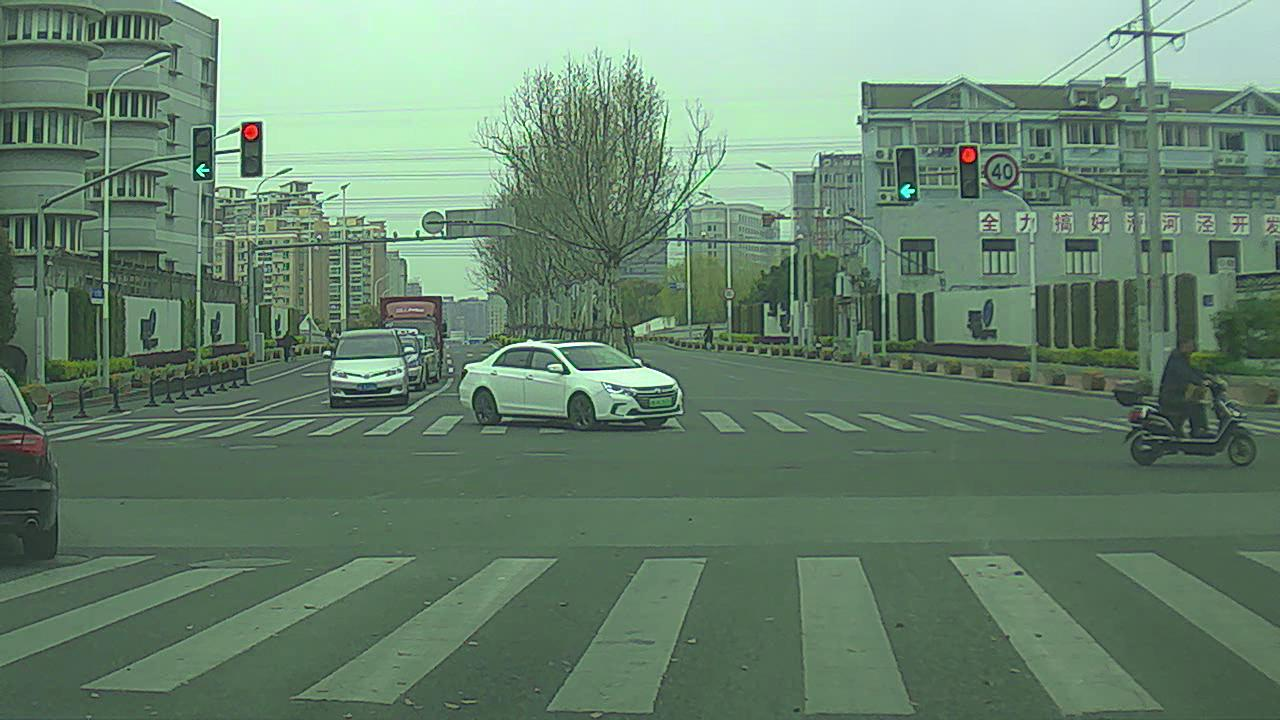

In [7]:
img = Image.open(img_path)
img

In [8]:
def aug_transform(image, boxes, labels, difficulties, split):
    """
    Apply the transformations above.

    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :param difficulties: difficulties of detection of these objects, a tensor of dimensions (n_objects)
    :param split: one of 'TRAIN' or 'TEST', since different sets of transformations are applied
    :return: transformed image, transformed bounding box coordinates, transformed labels, transformed difficulties
    """
    
    p = 0.5
    bbox_params=A.BboxParams(format='pascal_voc', min_area=100, min_visibility=0.1, label_fields=['labels'])
    
    assert split in {'TRAIN', 'TEST'}
    if split == 'TRAIN':
        list_of_augmentations = [A.HorizontalFlip(p=p),
                                 A.RandomBrightnessContrast(p=p, brightness_limit=(-0.30, 0.30),
                                                            contrast_limit=(-0.30, 0.30)),
                                 A.Blur(p=0.5, blur_limit=(1, 6)),
                                 A.CLAHE(p=0.5, clip_limit=(1, 24), tile_grid_size=(8, 8), always_apply=False),
                                 A.ISONoise(p=0.5, intensity=(0.1, 0.37), color_shift=(0.01, 0.20)),
                                 A.ImageCompression(p=0.5, always_apply=False, quality_lower=20, quality_upper=70,
                                                    compression_type=0),
                                 A.MotionBlur(p=0.5, always_apply=False, blur_limit=(5, 19), allow_shifted=False),
                                 A.PixelDropout(p=0.5, dropout_prob=0.05, per_channel=0, drop_value=(0, 0, 0),
                                                mask_drop_value=None),
                                 A.RandomGamma(p=0.5, gamma_limit=(65, 135), eps=None),
                                 A.RandomSnow(p=0.5, snow_point_lower=0.1, snow_point_upper=0.2, brightness_coeff=2.0)
                                ]
    elif split == 'TEST':
        list_of_augmentations = [A.Resize(300, 300)]
        
    transform = A.Compose(list_of_augmentations, bbox_params)
    
    new_image = np.array(image)
    new_difficulties = difficulties
    
    transformed = transform(image=new_image, bboxes=boxes, labels=labels)
    
    transformed_image = transformed['image']
    transformed_bboxes = transformed['bboxes']
    transformed_labels = transformed['labels']
    transformed_difficulties = difficulties
    
    return transformed_image, transformed_bboxes, transformed_labels, transformed_difficulties

In [9]:
PIL_image = np.array(Image.open(img_path))
boxes = torch.tensor(anno['boxes'])
labels = torch.tensor(anno['labels'])
difficulties = torch.tensor(anno['difficulties'])
split = "TRAIN"

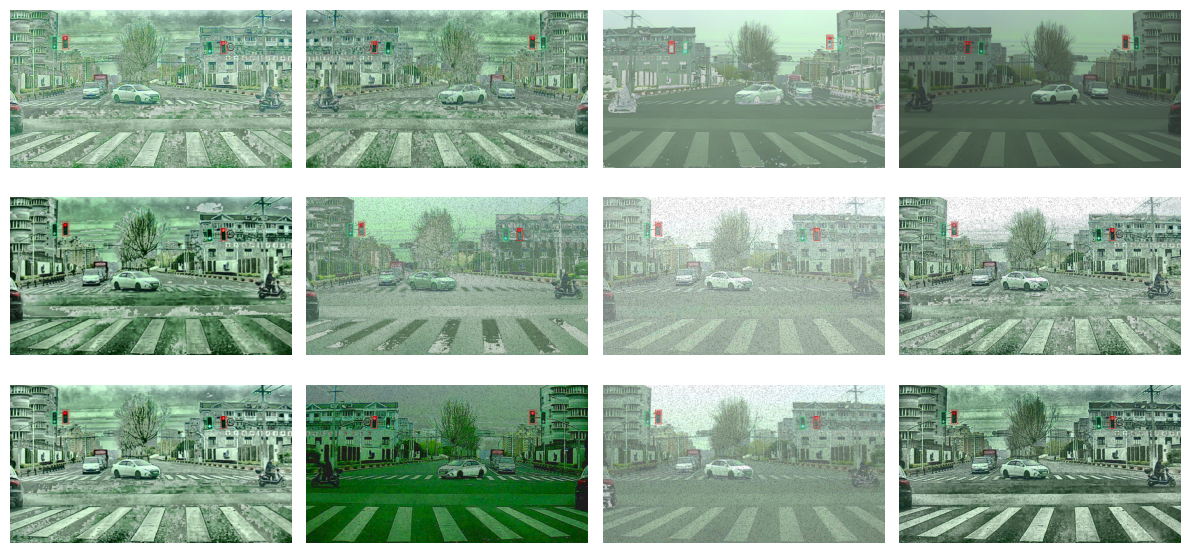

In [10]:
images = []
for i in range(12):
    aug_transformed = aug_transform(PIL_image, boxes, labels, difficulties, split)
    img = detect_image(Image.fromarray(aug_transformed[0]), 
                         {'boxes': aug_transformed[1], 'labels': aug_transformed[2], 'difficulties': aug_transformed[3]})
    images.append(img)
    
fig, axes = plt.subplots(3, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')
plt.tight_layout()
plt.show()   